# Regresión Lineal Múltiple: predecir los gastos médicos de pacientes

# 

## 1. Librerías y Datos

In [4]:
#!pip install regressors==0.0.3

In [5]:
#manipulación de datos
import numpy as np
import pandas as pd
#visualización
import seaborn as sns
import matplotlib.pyplot as plt
#preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
#Regresión
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#metricas y analisis del modelo
import sklearn.metrics as metrics
import regressors
from regressors import stats


In [6]:
df = pd.read_csv('datasets\insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Analizar Datos

In [7]:
# https://www.kaggle.com/datasets/mirichoi0218/insurance?select=insurance.csv


(1338, 7)


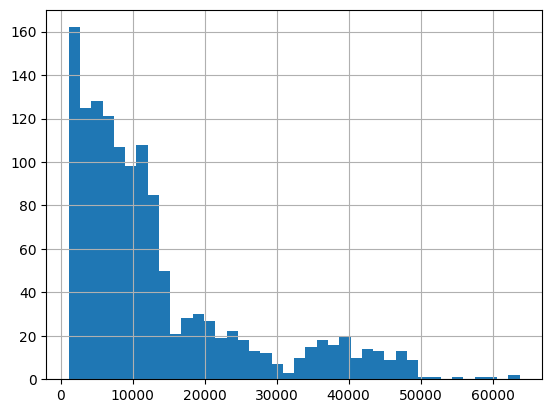

In [8]:
print(df.shape)
df.charges.hist(bins = 40)
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [11]:
# incluir sesgo y kurtosis en describe
df.charges.skew()


1.5158796580240388

In [12]:
# kurtois
df.charges.kurtosis()
# kurtois > 0, la distribución es más puntiaguda que la distribución normal

1.6062986532967907

In [13]:
# descripción de la variable categorica

df.describe(include = 'object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


<Axes: >

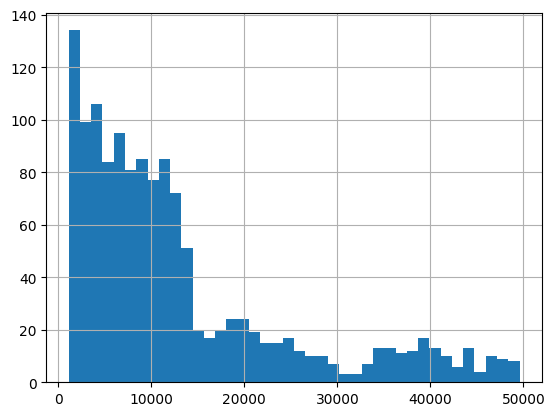

In [14]:
#eliminar mayores de 50,000
df_cortado = df[df.charges < 50000]
df_cortado.charges.hist(bins = 40)


<Axes: >

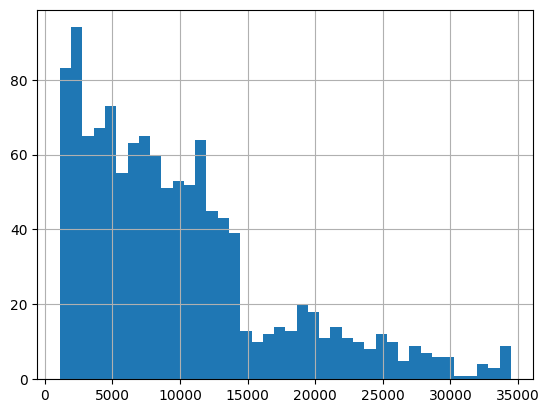

In [15]:
#función para eliminar outliers
def remove_outliers(df, column):
    df_1 = df.copy()
    q25, q75 = df_1[column].quantile(0.25), df_1[column].quantile(0.75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in df_1[column] if x < lower or x > upper]
    df_1 = df_1[(df[column] > lower) & (df_1[column] < upper)]
    return df_1
df_sin_outliers = remove_outliers(df, 'charges')
df_sin_outliers.charges.hist(bins = 40)

<Axes: >

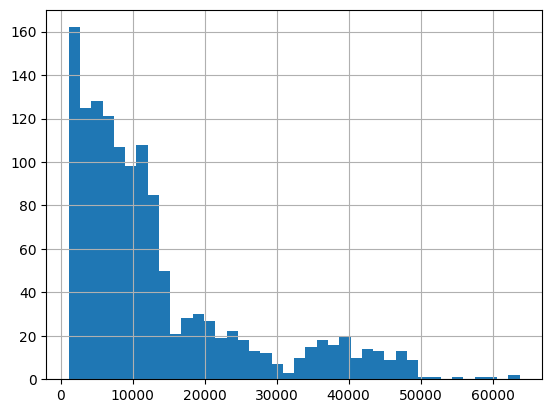

In [16]:
df.charges.hist(bins = 40)

NO siempre es bueno eliminar outliers sin antes consultar con un experto en el tema.

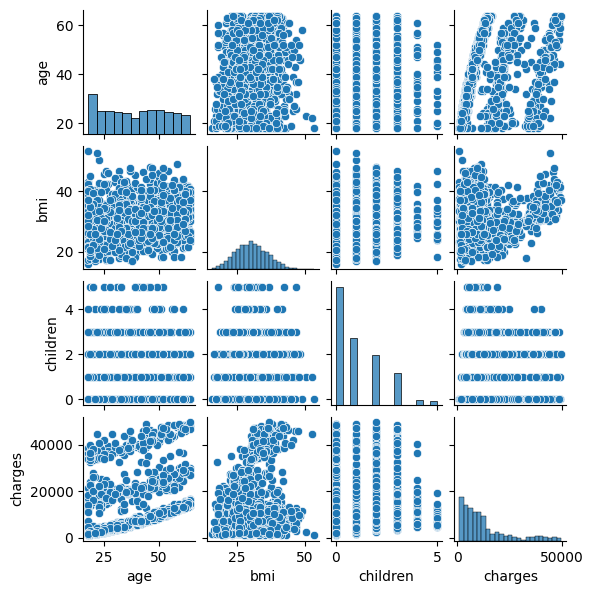

In [17]:
sns.pairplot(df_cortado, height=1.5)
plt.show()

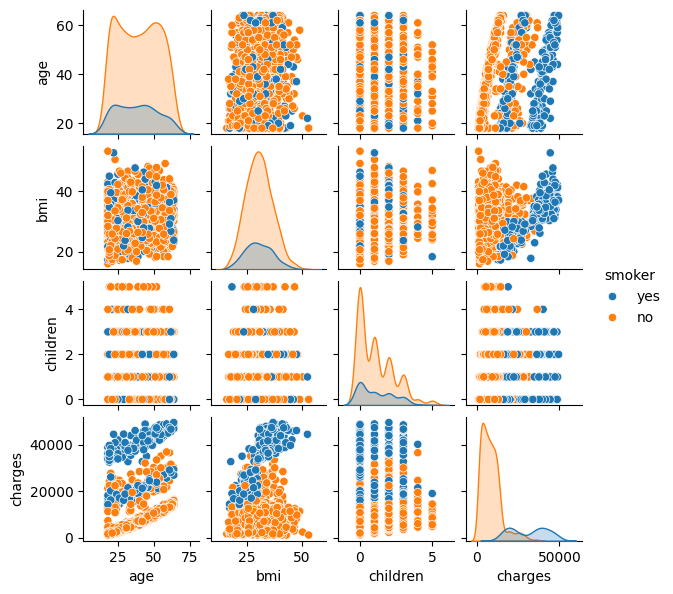

In [18]:
sns.pairplot(df_cortado, height=1.5, hue = 'smoker')
plt.show()

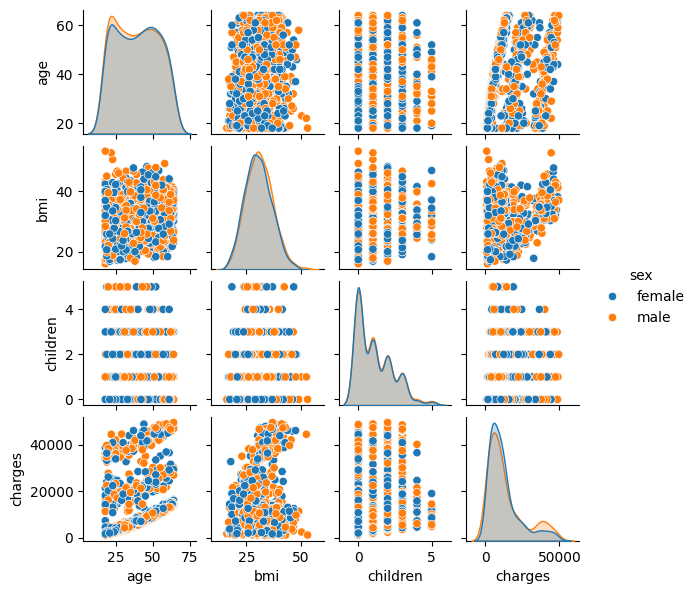

In [19]:
sns.pairplot(df_cortado, height=1.5, hue = 'sex')
plt.show()

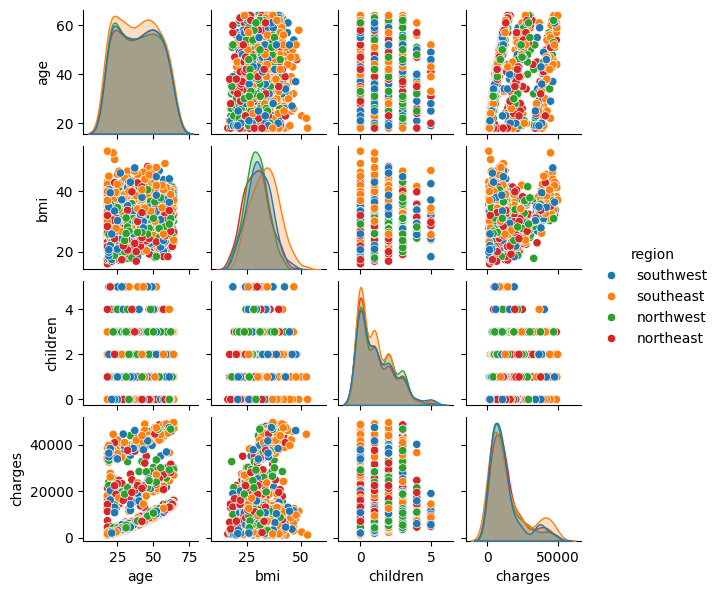

In [20]:
sns.pairplot(df_cortado, height=1.5, hue = 'region')
plt.show()

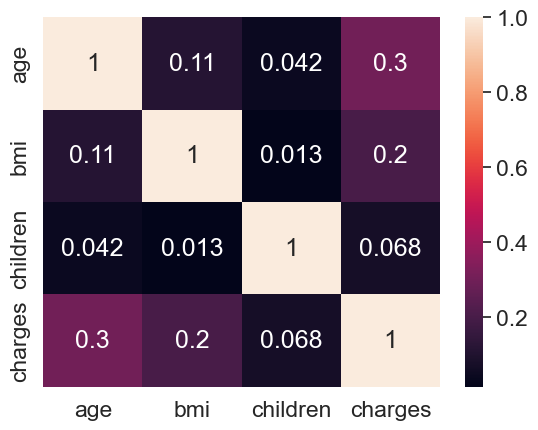

In [21]:
numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set_theme(font_scale=1.5)
sns.heatmap(cm,annot=True, yticklabels=numeric_cols,xticklabels=numeric_cols)
plt.show()

# Preproccesing

In [22]:
# one hot encoding, with HotEncoder


#creamos un objeto de la clase OneHotEncoder
# cols_categoricas = [colname for colname in df.columns if df[colname].dtype in ['object']]
categorical_cols = ['sex','smoker','region']
# instanciamos el objeto OneHotEncoder
ohe = OneHotEncoder(drop='first')
# ajustamos el objeto a los datos
ohe.fit(df_cortado[categorical_cols])
# transformamos los datos
new = ohe.transform(df_cortado[categorical_cols])
# convertimos el resultado a un DataFrame
df_one_hot_encoded = df_cortado.drop(columns=['sex', 'smoker', 'region'])
#df_one_hot_encoded = pd.DataFrame(new.toarray(), columns=ohe.get_feature_names_out())
df_one_hot_encoded[ohe.get_feature_names_out()] = new.toarray()

df_one_hot_encoded.head(5)



#df = pd.get_dummies(df, columns = ['sex', 'smoker', 'region'], drop_first = True)



,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0


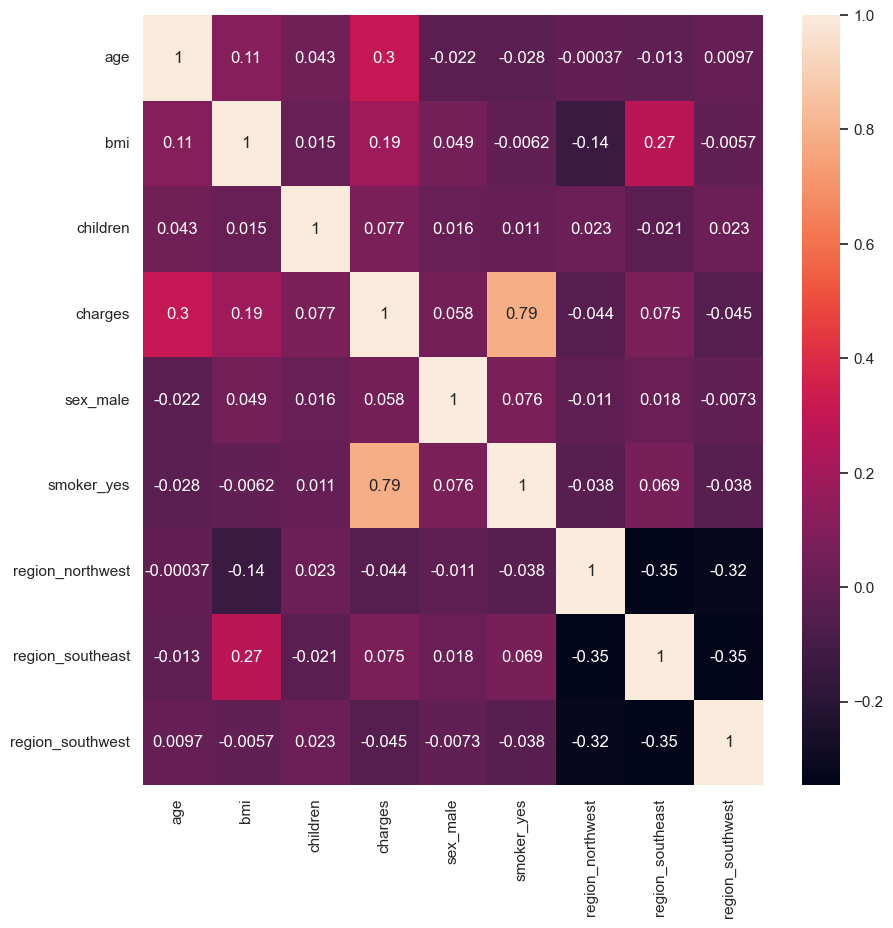

In [23]:
# ver correlaciones
columns = df_one_hot_encoded.columns
cm = np.corrcoef(df_one_hot_encoded.values.T)
plt.figure(figsize=(10,10))
sns.set_theme(font_scale=1)
sns.heatmap(cm,annot=True, yticklabels=columns,xticklabels=columns)
plt.show()

In [24]:
# separar en X y Y
X_cols = list(set(df_one_hot_encoded.columns) - set(['charges']))
y_col = ['charges']
X = df_one_hot_encoded[X_cols].values
y = df_one_hot_encoded[y_col].values



In [25]:
# StandardScaler
y_scaler = StandardScaler()
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)


(array([134.,  99., 106.,  84.,  95.,  81.,  85.,  77.,  85.,  72.,  51.,
         20.,  17.,  20.,  24.,  24.,  19.,  15.,  15.,  17.,  12.,  10.,
         10.,   7.,   3.,   3.,   7.,  13.,  13.,  11.,  12.,  17.,  13.,
         10.,   6.,  13.,   4.,  10.,   9.,   8.]),
 array([-1.01880615, -0.91522356, -0.81164097, -0.70805838, -0.60447579,
        -0.5008932 , -0.39731061, -0.29372802, -0.19014543, -0.08656284,
         0.01701975,  0.12060234,  0.22418493,  0.32776752,  0.43135011,
         0.5349327 ,  0.63851529,  0.74209787,  0.84568046,  0.94926305,
         1.05284564,  1.15642823,  1.26001082,  1.36359341,  1.467176  ,
         1.57075859,  1.67434118,  1.77792377,  1.88150636,  1.98508895,
         2.08867154,  2.19225413,  2.29583672,  2.39941931,  2.5030019 ,
         2.60658449,  2.71016708,  2.81374967,  2.91733226,  3.02091484,
         3.12449743]),
 <BarContainer object of 40 artists>)

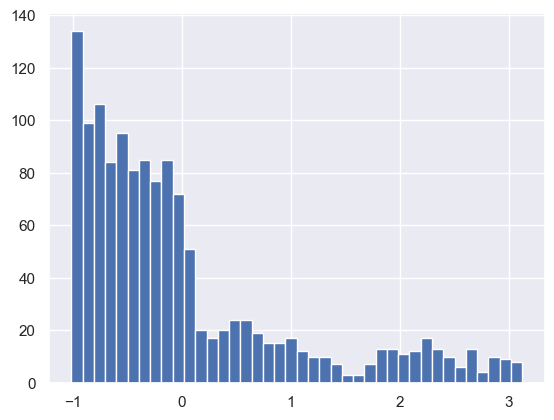

In [26]:
# y_scaled hist
plt.hist(y_scaled, bins = 40)

In [27]:
# y_scaled describe
y_scaled = pd.DataFrame(y_scaled, columns = y_col)
y_scaled.describe()

,charges
count,1.331000e+03
mean,4.404191e-17
std,1.000376e+00
min,-1.018806e+00
25%,-7.111732e-01
50%,-3.193581e-01
75%,2.840876e-01
max,3.124497e+00


## Entrenar el modelo

In [28]:
# train test split
rs = 23
X_train_std,X_test_std,y_train_std,y_test_std= train_test_split(X_scaled,y_scaled,train_size=0.8, random_state=rs)


model_1 = LinearRegression()
model_1.fit(X_train_std,y_train_std)
y_train_pred = model_1.predict(X_train_std)
y_test_pred = model_1.predict(X_test_std)



## 3. Analizando el modelo

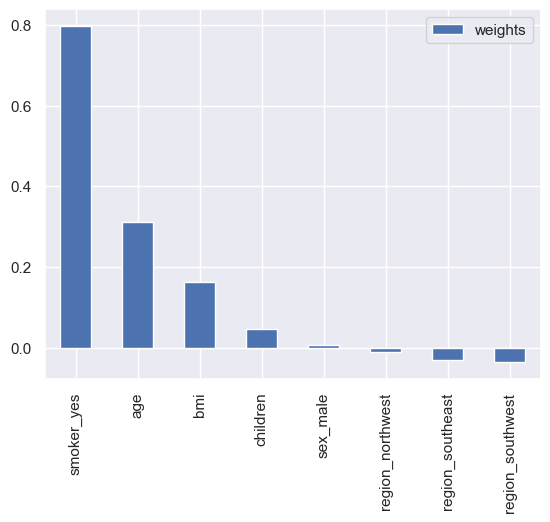

In [29]:
# ver pesos de las variables y graficar
weights = model_1.coef_
weights = pd.DataFrame(weights, columns = X_cols)
weights = weights.T
weights.columns = ['weights']
weights = weights.sort_values(by = 'weights', ascending = False)
weights.plot(kind = 'bar')
plt.show()

In [30]:
# intercepto
intercept = model_1.intercept_
print(intercept)


[-7.98678515e-05]


## 4. Evaluando el modelo

In [31]:
y_predict = model_1.predict(X_train_std)

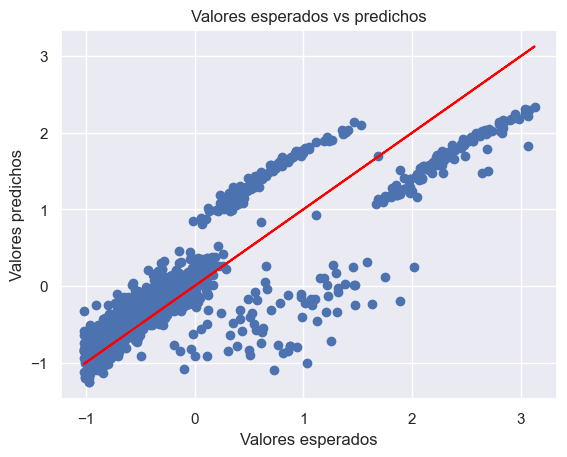

In [32]:
# Comparar valores esperados vs predichos
plt.scatter(y_train_std, y_predict)
# graficar la recta y = x
plt.plot(y_train_std, y_train_std, color = 'red')

plt.xlabel('Valores esperados')
plt.ylabel('Valores predichos')
plt.title('Valores esperados vs predichos')
plt.show()



In [33]:
# calcular metricas
mse = metrics.mean_squared_error(y_train_std,y_predict)
r2 = metrics.r2_score(y_train_std, y_predict)



print("r2 ", r2.round(4))
print("mse: ", mse.round(4))

r2  0.7564
mse:  0.2453


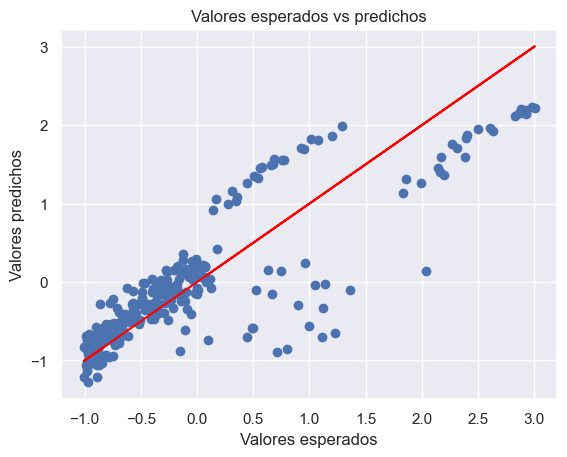

In [34]:
# aplicar el modelo a test
y_predict_test = model_1.predict(X_test_std)

# ver graficamente
plt.scatter(y_test_std, y_predict_test)
# graficar la recta y = x
plt.plot(y_test_std, y_test_std, color = 'red')

plt.xlabel('Valores esperados')
plt.ylabel('Valores predichos')
plt.title('Valores esperados vs predichos')
plt.show()


In [35]:
# calcular metricas
mse_test = metrics.mean_squared_error(y_test_std,y_predict_test)
r2_test = metrics.r2_score(y_test_std, y_predict_test)

print("r2_test ", r2_test.round(4))
print("mse_test: ", mse_test.round(4))


r2_test  0.7366
mse_test:  0.2555


In [36]:
# crear función para evaluar el modelo
def evaluar_modelo(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mse_train = metrics.mean_squared_error(y_train,y_train_pred)
    r2_train = metrics.r2_score(y_train, y_train_pred)
    mse_test = metrics.mean_squared_error(y_test,y_test_pred)
    r2_test = metrics.r2_score(y_test, y_test_pred)
    return mse_train, r2_train, mse_test, r2_test

# función para ver los coeficientes
def ver_coeficientes(model, X):
    weights = model.coef_
    weights = pd.DataFrame(weights, columns = X.columns)
    weights = weights.T
    weights.columns = ['weights']
    weights = weights.sort_values(by = 'weights', ascending = False)
    weights.plot(kind = 'bar')
    plt.show()
    return weights

# función para ver los residuos
def ver_residuos(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    residuos_train = y_train - y_train_pred
    residuos_test = y_test - y_test_pred
    #plt.scatter(y_train_pred, residuos_train)
    plt.scatter(y_test_pred, residuos_test)
    plt.axhline(0, color = 'red')
    plt.show()
    return residuos_train, residuos_test

# función para ver la distribución de los residuos
def ver_distribucion_residuos(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    residuos_train = y_train - y_train_pred
    residuos_test = y_test - y_test_pred
    sns.histplot(residuos_train, kde = True)
    sns.histplot(residuos_test, kde = True)
    plt.show()
    return residuos_train, residuos_test
# función para ver predichos vs esperados
def ver_predichos_vs_esperados(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    #plt.scatter(y_train, y_train_pred)
    plt.scatter(y_test, y_test_pred)
    plt.plot(y_train, y_train, color = 'red')
    plt.show()
    return y_train_pred, y_test_pred

# función para evaluar el modelo y ver predichos vs esperados en test
def evaluar_modelo_completo(model, X_train, y_train, X_test, y_test):
    mse_train, r2_train, mse_test, r2_test = evaluar_modelo(model, X_train, y_train, X_test, y_test)
    print("mse_train: ", mse_train.round(4))
    print("r2_train: ", r2_train.round(4))
    print("mse_test: ", mse_test.round(4))
    print("r2_test: ", r2_test.round(4))
    ver_predichos_vs_esperados(model, X_train, y_train, X_test, y_test)
    #ver_residuos(model, X_train, y_train, X_test, y_test)
    #ver_distribucion_residuos(model, X_train, y_train, X_test, y_test)
    ver_coeficientes(model, X_train)
    

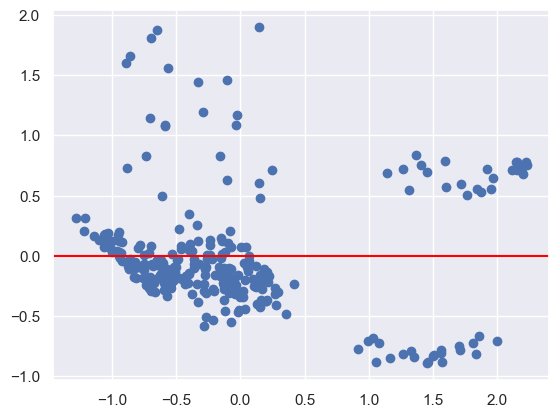

In [37]:
# ver residuos
_ =ver_residuos(model_1, X_train_std, y_train_std, X_test_std, y_test_std)


In [38]:
# evaluar con regressors
# guardar coeficientes
model_1.intercept_ = model_1.intercept_[0]
model_1.coef_ = model_1.coef_.reshape(-1)
# guardar test
y_test_std = y_test_std.values.reshape(-1)


# make a summary
stats.summary(model_1, X_test_std, y_test_std ,X_cols)


Residuals:
    Min      1Q  Median     3Q    Max
-1.8995 -0.1178  0.0997 0.2477 0.8901


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.000080    0.031161  -0.0026  0.997957
region_southeast -0.030030    0.036613  -0.8202  0.412836
age               0.310531    0.030530  10.1713  0.000000
region_northwest -0.011452    0.036577  -0.3131  0.754455
children          0.047769    0.032905   1.4517  0.147759
bmi               0.164200    0.031800   5.1635  0.000000
smoker_yes        0.796690    0.033052  24.1043  0.000000
region_southwest -0.035821    0.035520  -1.0085  0.314147
sex_male          0.006493    0.031064   0.2090  0.834603
---
R-squared:  0.73664,    Adjusted R-squared:  0.72847
F-statistic: 90.20 on 8 features


In [45]:
def summarize_model(model, X_test, y_test, X_cols):
    model.intercept_ = model.intercept_[0]
    model.coef_ = model.coef_.reshape(-1)
    #y_test = y_test.values.reshape(-1)
    return stats.summary(model, X_test, y_test, X_cols)

## Entrenar con mas variables

In [40]:
df_2 = df_one_hot_encoded.copy()
df_2['edad_al_cuadrado'] = df_2['age']**2
df_2['sobrepeso'] = (df_2['bmi'] >= 30).astype(int)
df_2['sobrepeso*fumador'] = df_2['sobrepeso']*df_2['smoker_yes']



In [54]:
# entrenar segundo modelo
X_cols_2 = list(set(df_2.columns) - set(['charges']))
y_col_2 = ['charges']
X_2 = df_2[X_cols_2].values
y_2 = df_2[y_col_2].values

# StandardScaler
y_scaler_2 = StandardScaler()
X_scaler_2 = StandardScaler()
X_scaled_2 = X_scaler_2.fit_transform(X_2)
y_scaled_2 = y_scaler_2.fit_transform(y_2)

# train test split
rs = 23
X_train_std_2,X_test_std_2,y_train_std_2,y_test_std_2= train_test_split(X_scaled_2,y_scaled_2,train_size=0.8, random_state=rs)

model_2 = LinearRegression() #intercept = False
model_2.fit(X_train_std_2,y_train_std_2)
y_train_pred_2 = model_2.predict(X_train_std_2)

In [ ]:
#

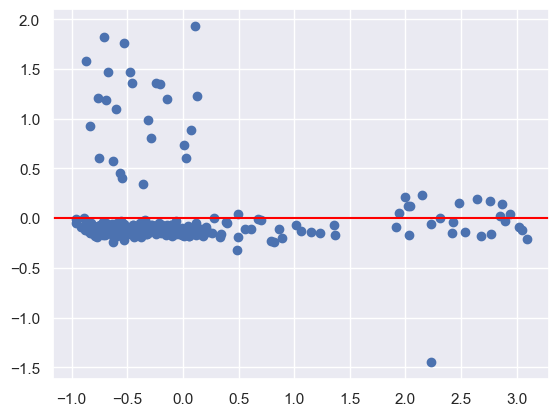

In [42]:
# ver residuales
_ =ver_residuos(model_2, X_train_std_2, y_train_std_2, X_test_std_2, y_test_std_2)

In [55]:
# ver analisis estadistico
model_2.intercept_ = model_2.intercept_[0]
model_2.coef_ = model_2.coef_.reshape(-1)
# guardar test
y_test_std_2 = y_test_std_2.reshape(-1)


# make a summary


AssertionError: Dimension of xlabels (8,) does not match X (267, 11).

In [56]:
stats.summary(model_2, X_test_std_2, y_test_std_2 ,X_cols_2)

Residuals:
    Min     1Q  Median     3Q    Max
-1.9324 0.0656  0.1054 0.1417 1.4468


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept        -0.000896    0.024116  -0.0371  0.970396
region_southeast  -0.019182    0.028344  -0.6767  0.499154
sobrepeso         -0.048435    0.038926  -1.2443  0.214496
age               -0.038517    0.125956  -0.3058  0.759998
region_northwest   0.000701    0.028310   0.0248  0.980256
children           0.064696    0.025669   2.5204  0.012308
bmi                0.058580    0.037708   1.5535  0.121491
sobrepeso*fumador  0.496649    0.035568  13.9632  0.000000
smoker_yes         0.465491    0.034795  13.3779  0.000000
edad_al_cuadrado   0.363062    0.126739   2.8646  0.004508
region_southwest  -0.033194    0.027581  -1.2035  0.229852
sex_male          -0.007186    0.024043  -0.2989  0.765262
---
R-squared:  0.84282,    Adjusted R-squared:  0.83604
F-statistic: 124.30 on 11 features


## Eliminando Variables

In [57]:
# entrenar segundo modelo
X_cols_2 = ['smoker_yes', 'edad_al_cuadrado', 'sobrepeso', 'sobrepeso*fumador','children',]
y_col_2 = ['charges']
X_2 = df_2[X_cols_2].values
y_2 = df_2[y_col_2].values

# StandardScaler
y_scaler_2 = StandardScaler()
X_scaler_2 = StandardScaler()
X_scaled_2 = X_scaler_2.fit_transform(X_2)
y_scaled_2 = y_scaler_2.fit_transform(y_2)

# train test split
rs = 23
X_train_std_2,X_test_std_2,y_train_std_2,y_test_std_2= train_test_split(X_scaled_2,y_scaled_2,train_size=0.8, random_state=rs)

model_2 = LinearRegression() #intercept = False
model_2.fit(X_train_std_2,y_train_std_2)
y_train_pred_2 = model_2.predict(X_train_std_2)

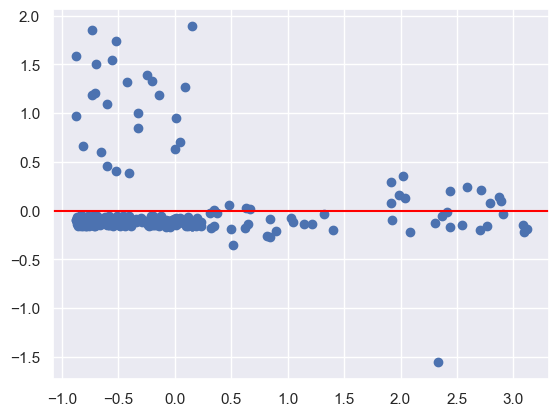

In [58]:
_ =ver_residuos(model_2, X_train_std_2, y_train_std_2, X_test_std_2, y_test_std_2)

In [59]:
# ver analisis estadistico
model_2.intercept_ = model_2.intercept_[0]
model_2.coef_ = model_2.coef_.reshape(-1)
# guardar test
y_test_std_2 = y_test_std_2.reshape(-1)
stats.summary(model_2, X_test_std_2, y_test_std_2 ,X_cols_2)

# make a summary

Residuals:
    Min     1Q  Median     3Q    Max
-1.8933 0.0723  0.1098 0.1335 1.5543


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept        -0.001340    0.024385  -0.0549  0.956225
smoker_yes         0.465160    0.034893  13.3309  0.000000
edad_al_cuadrado   0.328397    0.023877  13.7535  0.000000
sobrepeso         -0.006192    0.026134  -0.2369  0.812895
sobrepeso*fumador  0.496559    0.035630  13.9365  0.000000
children           0.063074    0.025723   2.4520  0.014849
---
R-squared:  0.83839,    Adjusted R-squared:  0.83530
F-statistic: 270.81 on 5 features


# Modelo Final

In [64]:
# entrenar segundo modelo
X_cols_2 = ['smoker_yes', 'edad_al_cuadrado' , 'sobrepeso*fumador','children',]
y_col_2 = ['charges']
X_2 = df_2[X_cols_2].values
y_2 = df_2[y_col_2].values

# StandardScaler
y_scaler_2 = StandardScaler()
X_scaler_2 = StandardScaler()
X_scaled_2 = X_scaler_2.fit_transform(X_2)
y_scaled_2 = y_scaler_2.fit_transform(y_2)

# train test split
rs = 23
X_train_std_2,X_test_std_2,y_train_std_2,y_test_std_2= train_test_split(X_scaled_2,y_scaled_2,train_size=0.8, random_state=rs)

model_2 = LinearRegression(fit_intercept=False) #intercept = False
model_2.fit(X_train_std_2,y_train_std_2)
y_train_pred_2 = model_2.predict(X_train_std_2)

In [66]:
# ver analisis estadistico
model_2.coef_ = model_2.coef_.reshape(-1)
# guardar test
y_test_std_2 = y_test_std_2.reshape(-1)
stats.summary(model_2, X_test_std_2, y_test_std_2 ,X_cols_2)

# make a summary

Residuals:
    Min     1Q  Median     3Q    Max
-1.8868 0.0741  0.1113 0.1344 1.5555


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.024276   0.0000  1.000000
smoker_yes         0.467665    0.033519  13.9522  0.000000
edad_al_cuadrado   0.327955    0.023641  13.8723  0.000000
sobrepeso*fumador  0.492792    0.033049  14.9110  0.000000
children           0.062993    0.025683   2.4527  0.014821
---
R-squared:  0.83880,    Adjusted R-squared:  0.83634
F-statistic: 340.83 on 4 features
